In [954]:
import numpy as np
import pandas as pd 
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/pokemon-stats/PokemonDB_with_Stage.csv


# Setup

In [955]:
data = pd.read_csv('../input/pokemon-stats/PokemonDB_with_Stage.csv', header = 0) #read from dataset
data.drop(['#', 'Name', 'Variation', 'Type1', 'Type2'], axis = 1, inplace = True)
data.head() # view first few rows of the data

# Load the Iris dataset as an example
X = data.iloc[:,: -1] # read input columns
y = data.iloc[:,-1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)

# Undersampling

In [956]:
'''''
from sklearn.utils import resample

# Identify the subset of data corresponding to stage 3 evolution
stage_3_data = data[data['Evolution Stage'] == 3]

# Undersample the majority class (stage 1 and 2) to match the minority class
undersampled_majority_data = resample(data[data['Evolution Stage'] != 3], replace=False, n_samples=len(stage_3_data), random_state=42)

# Combine the undersampled majority data with the stage 3 data
undersampled_df = pd.concat([undersampled_majority_data, stage_3_data])

# Shuffle the combined dataset to mix the undersampled majority data and stage 3 data
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

print(undersampled_df)

X = undersampled_df.iloc[:,: -1] # read input columns
y = undersampled_df.iloc[:,-1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)
'''''

"''\nfrom sklearn.utils import resample\n\n# Identify the subset of data corresponding to stage 3 evolution\nstage_3_data = data[data['Evolution Stage'] == 3]\n\n# Undersample the majority class (stage 1 and 2) to match the minority class\nundersampled_majority_data = resample(data[data['Evolution Stage'] != 3], replace=False, n_samples=len(stage_3_data), random_state=42)\n\n# Combine the undersampled majority data with the stage 3 data\nundersampled_df = pd.concat([undersampled_majority_data, stage_3_data])\n\n# Shuffle the combined dataset to mix the undersampled majority data and stage 3 data\nundersampled_df = undersampled_df.sample(frac=1, random_state=42)\n\nprint(undersampled_df)\n\nX = undersampled_df.iloc[:,: -1] # read input columns\ny = undersampled_df.iloc[:,-1]\n\n# Split the data into training and testing sets\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)\n"

# Oversampling

In [957]:

from sklearn.utils import resample

# Assuming 'df' is your DataFrame containing Pokémon data
# Replace these columns and values with your actual columns and values

# Identify the subset of data corresponding to stage 3 evolution
stage_3_data = data[data['Evolution Stage'] == 3]

# Oversample the minority class (stage 3) to match the majority class
oversampled_stage_3_data = resample(stage_3_data, replace=True, n_samples=len(data[data['Evolution Stage'] == 1]), random_state=42)

# Combine the oversampled stage 3 data with the original data
oversampled_df = pd.concat([data, oversampled_stage_3_data])

# Shuffle the combined dataset to mix the original and oversampled data
oversampled_df = oversampled_df.sample(frac=1, random_state=42)

X = oversampled_df.iloc[:,: -1] # read input columns
y = oversampled_df.iloc[:,-1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 42)


# Logistic Regression

In [958]:
lrm = LogisticRegression(multi_class = 'multinomial', max_iter = 1000, solver = "sag", 
                         class_weight = {1:1,2:1,3:1})

lrm.fit(X_train, y_train)

y_pred = lrm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.4794520547945205
              precision    recall  f1-score   support

           1       0.63      0.22      0.32       134
           2       0.60      0.04      0.07        80
           3       0.46      0.95      0.62       151

    accuracy                           0.48       365
   macro avg       0.56      0.40      0.34       365
weighted avg       0.55      0.48      0.39       365



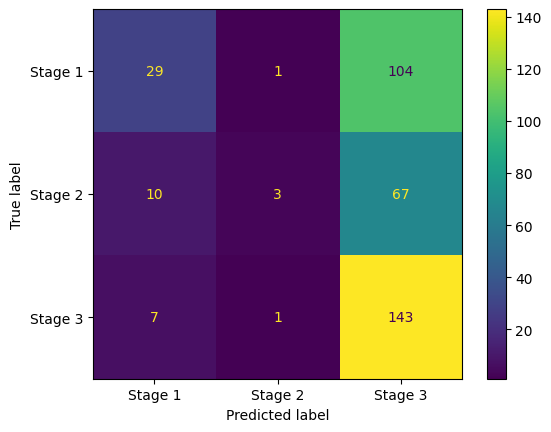

In [959]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Stage 1', 'Stage 2', 'Stage 3']).plot()

# Grid Search for Logistic Regression

In [960]:
# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(lrm, param_grid, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
# Train the final model using the best hyperparameters
best_model = LogisticRegression(multi_class = 'ovr', max_iter=1000, **best_params)
best_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)


Best Hyperparameters: {'C': 0.001, 'penalty': 'l2'}
Accuracy: 0.6712328767123288


# Random Forest

In [961]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

y_pred = random_forest_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8931506849315068
              precision    recall  f1-score   support

           1       0.91      0.85      0.88       134
           2       0.77      0.80      0.79        80
           3       0.94      0.98      0.96       151

    accuracy                           0.89       365
   macro avg       0.88      0.88      0.88       365
weighted avg       0.89      0.89      0.89       365



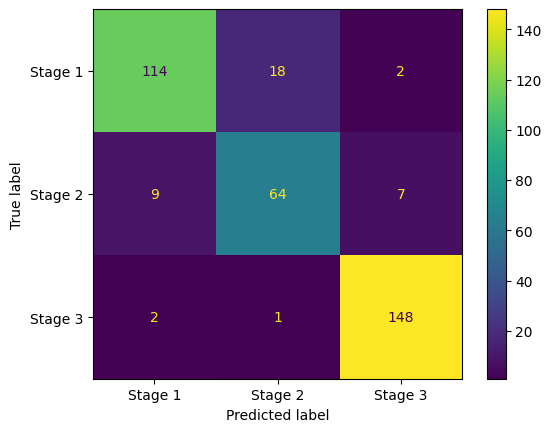

In [962]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Stage 1', 'Stage 2', 'Stage 3']).plot()

# Neural Networks

In [963]:
# Create a binary classification label: 0 for early stages, 1 for advanced stages
data['Binary_Evolution_Stage'] = np.where(data['Evolution Stage'].isin([2, 3]), 1, 0)

# Drop the original 'Evolution_Stage' column if no longer needed
data.drop('Evolution Stage', axis=1, inplace=True)

# Separate features and labels
X = data.drop('Binary_Evolution_Stage', axis=1)
y = data['Binary_Evolution_Stage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [964]:
# Assuming y_train is an array of string labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Ensure the encoded labels are integers
y_train_encoded = y_train_encoded.astype(int)


model = Sequential([
    Dense(units = 25, activation="relu"),
    Dense(units = 15, activation="relu"),
    Dense(units = 3, activation="softmax")
                ])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss = SparseCategoricalCrossentropy()
            )

model.fit(X_train, y_train_encoded, epochs = 10)

Epoch 1/10
30/30 [==============================] - 1s 2ms/step - loss: 56.8148
Epoch 2/10
30/30 [==============================] - 0s 2ms/step - loss: 5.7087
Epoch 3/10
30/30 [==============================] - 0s 2ms/step - loss: 1.0576
Epoch 4/10
30/30 [==============================] - 0s 2ms/step - loss: 0.9070
Epoch 5/10
30/30 [==============================] - 0s 2ms/step - loss: 0.8220
Epoch 6/10
30/30 [==============================] - 0s 2ms/step - loss: 0.7625
Epoch 7/10
30/30 [==============================] - 0s 2ms/step - loss: 0.7343
Epoch 8/10
30/30 [==============================] - 0s 2ms/step - loss: 0.7227
Epoch 9/10
30/30 [==============================] - 0s 2ms/step - loss: 0.7156
Epoch 10/10
30/30 [==============================] - 0s 2ms/step - loss: 0.7114


In [965]:
yts_pred = tf.nn.softmax(model.predict(X_train))
confusion_matrix = tf.math.confusion_matrix(tf.argmax(yts_pred, axis=1),  y_train_encoded, num_classes=3).numpy()

# print(yts_pred)

print(confusion_matrix)

# cm = confusion_matrix(y_test, yts_pred)
# ConfusionMatrixDisplay(cm, display_labels=['Stage 1', 'Stage 2', 'Stage 3']).plot()

acc = 0
total = 0

for i in range(len(confusion_matrix)):
    acc += confusion_matrix[i][i]
    for j in range(3):
        total += confusion_matrix[i][j]
        
print("Accuracy on test data set: ", (acc/total))

30/30 [==============================] - 0s 1ms/step
[[341 256   0]
 [167 188   0]
 [  0   0   0]]
Accuracy on test data set:  0.555672268907563
